In [66]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
def import_sys():
    import sys
    sys.path.append('..')
    sys.path.append('../..')
import_sys()

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import errudite
from errudite.io import DatasetReader
DATASET_FOLDER = errudite.utils.normalize_file_path("~/datasets/raw_data/mrqa/")
MODEL_FOLDER = errudite.utils.normalize_file_path("~/datasets/models/mrqa/")
reader = DatasetReader.by_name("mrqa")(
    cache_folder_path="~/datasets/caches/dataset_debug/mrqa-all")

INFO:errudite.utils.file_utils:Errudite cache folder selected: /Users/tongshuangwu/datasets/caches/dataset_debug/mrqa-all


In [3]:
reader.load_preprocessed()

INFO:errudite.io.dataset_reader:Loaded 67857 objects to /Users/tongshuangwu/datasets/caches/dataset_debug/mrqa-all/instances.pkl.
INFO:errudite.io.dataset_reader:Loaded 67857 objects to /Users/tongshuangwu/datasets/caches/dataset_debug/mrqa-all/evaluations/mrqa_path.pkl.


In [4]:
from errudite.targets.instance import Instance
Instance.instance_entries

['question', 'context', 'groundtruths', 'predictions']

In [5]:
from errudite.predictors import Predictor

bert_baseline = Predictor.by_name("mrqa")(
    name='mrqa_path', 
    description='Pretrained BERT baseline model from MRQA website.')

INFO:pytorch_pretrained_bert.modeling:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
/Users/tongshuangwu/sourcetree/errudite_dataset_debug/venv/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [6]:
## check the model performance.
from collections import defaultdict
dataset_instances = defaultdict(list)
for instance in Instance.instance_hash.values():
    dataset_instances[instance.question.metas["dataset"]].append(instance)
import pandas as pd
performances = []
for dataset, instances in dataset_instances.items():
    bert_baseline.evaluate_performance(instances)
    output = {"predictor": bert_baseline.name, "dataset": dataset, "size": len(instances)}
    output.update(bert_baseline.perform)
    performances.append(output)
    
pd.DataFrame(performances)

,confidence,dataset,em,f1,precision,predictor,recall,sent,size
0,10.769357,HotpotQA,0.593835,0.756571,0.779675,mrqa_path,0.784749,0.836043,5904
1,10.565223,NaturalQuestionsShort,0.621222,0.742887,0.784824,mrqa_path,0.756345,0.829152,12836
2,10.921372,TriviaQA-web,0.635710,0.694725,0.687495,mrqa_path,0.739671,0.778292,7785
3,9.755813,NewsQA,0.470085,0.620765,0.642255,mrqa_path,0.653081,0.625119,4212
4,11.130991,SearchQA,0.682273,0.752756,0.743698,mrqa_path,0.802909,0.812014,16980
5,10.007112,SQuAD,0.784525,0.866238,0.870957,mrqa_path,0.889903,0.948320,10507
6,5.885415,RACE,0.305638,0.415701,0.428486,mrqa_path,0.447139,0.494065,674
7,9.051775,DuoRC.ParaphraseRC,0.434377,0.522962,0.523983,mrqa_path,0.554041,0.674883,1501
8,8.453501,DROP,0.258150,0.345466,0.353842,mrqa_path,0.379322,0.673985,1503
9,7.468129,BioASQ,0.460771,0.593583,0.599858,mrqa_path,0.635553,0.823138,1504


In [11]:
# load built attributes and groups.
from tqdm import tqdm
from errudite.builts import Group, Attribute
from errudite.targets import Instance
Attribute.import_from_file("save_attr.json")
instance_groups = Instance.create_instance_dicts()
for a in tqdm(Attribute.values()):
    # on init, do not allow cross reference between attrs and groups
    a.set_instances(a.cmd, instance_groups, attr_hash=Attribute.store_hash())
Group.import_from_file("save_group.json")
for a in tqdm(Group.values()):
    a.set_instances(a.cmd, instance_groups, 
        attr_hash=Attribute.store_hash(), group_hash=Group.store_hash())

[autoreload of errudite.build_blocks.prim_funcs.linguistic failed: Traceback (most recent call last):
  File "/Users/tongshuangwu/sourcetree/errudite_dataset_debug/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tongshuangwu/sourcetree/errudite_dataset_debug/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/Users/tongshuangwu/sourcetree/errudite_dataset_debug/venv/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/tongshuangwu/sourcetree/errudite_dataset_debug/venv/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  F

KeyboardInterrupt: 

In [55]:
import altair as alt

# define a function that can visualize the dataset distribution, based on selected group
def visualize_dataset_attr_on_a_group(group_name=None):
    if not Group.exists(group_name):
        filtered_instances = None
    else:
        filtered_instances = Group.get(group_name).get_instance_list()
    attr_viz = []
    attr_name = "dataset"
    for normalize in [False, True]:
        attr_viz.append(Attribute.get(attr_name) \
                .visualize_per_model(filtered_instances=filtered_instances, normalize=normalize) \
                .properties(title=f"{attr_name} on {group_name}"))
    return alt.hconcat(*attr_viz)

# define a function that can iterate through all the dataset groups and visualize the distribution, both not normalized and normalized
def visualize_attr_by_dataset_group(attr_name):
    if not Attribute.exists(attr_name):
        return None
    dataset_groups = [ g for g in Group.values() if g.cmd.startswith("attr:dataset") ]
    output1, output2 = [], []
    for g in tqdm(dataset_groups):
        attr_viz = []
        for normalize in [False, True]:
            attr_viz.append(Attribute.get(attr_name) \
                .visualize_per_model(filtered_instances=g.get_instance_list(), normalize=normalize) \
                .properties(title=f"{attr_name} on {g.name}"))
        output1.append(attr_viz[0])
        output2.append(attr_viz[1])
    return alt.hconcat(alt.vconcat(*output1).resolve_scale(x="shared"), alt.vconcat(*output2).resolve_scale(x="shared"))#.resolve_scale(x="shared")

## Overall distribution

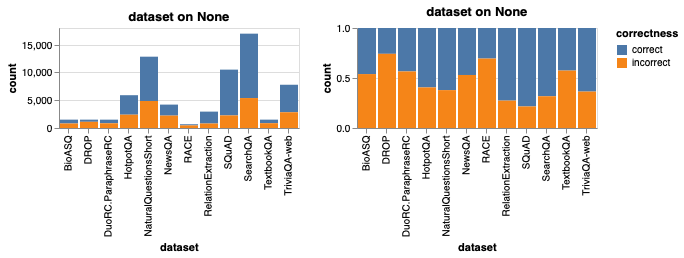

In [40]:
visualize_dataset_attr_on_a_group()

## Filtering making some datasets to pop-up

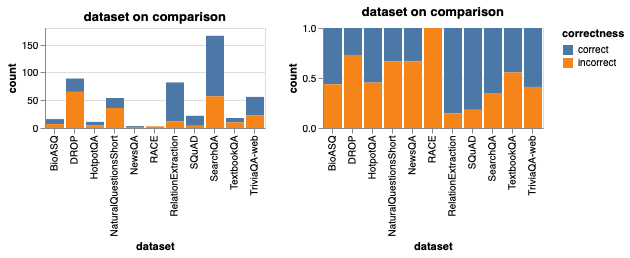

In [61]:
# has_pattern(NOUN or NOUN)
visualize_dataset_attr_on_a_group("comparison")

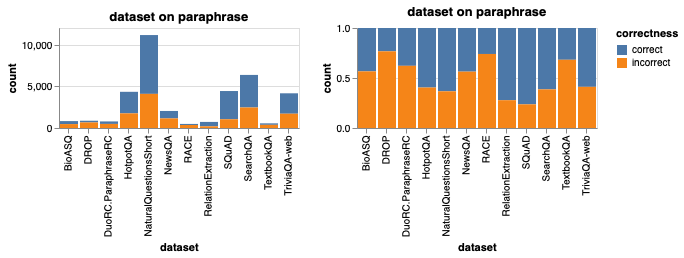

In [58]:
# the correct/incorrect distribution doesn't seem to change much, but the NaturalQuestionShort seem to have much more paraphasing?
visualize_dataset_attr_on_a_group("paraphrase")

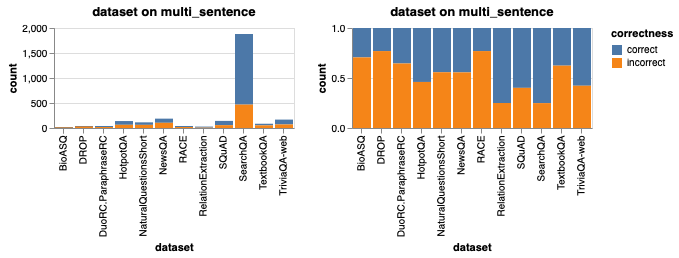

In [59]:
# Whereas SearchQA is very significant on taking multiple sentences?
visualize_dataset_attr_on_a_group("multi_sentence")

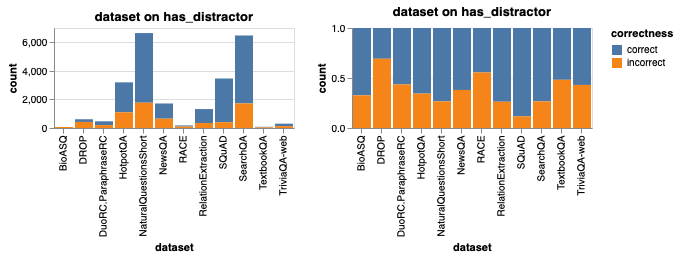

In [62]:
visualize_dataset_attr_on_a_group("has_distractor")

## Attribute distribution difference for different datasets

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(truncate):[ArgOp:[BuildBlockOp](attr):question_length, ArgOp:0.0, ArgOp:50.0]+[]
INFO:errudite.builts.attribute:Created attr: question_length_truncate
100%|██████████| 12/12 [00:01<00:00,  6.52it/s]


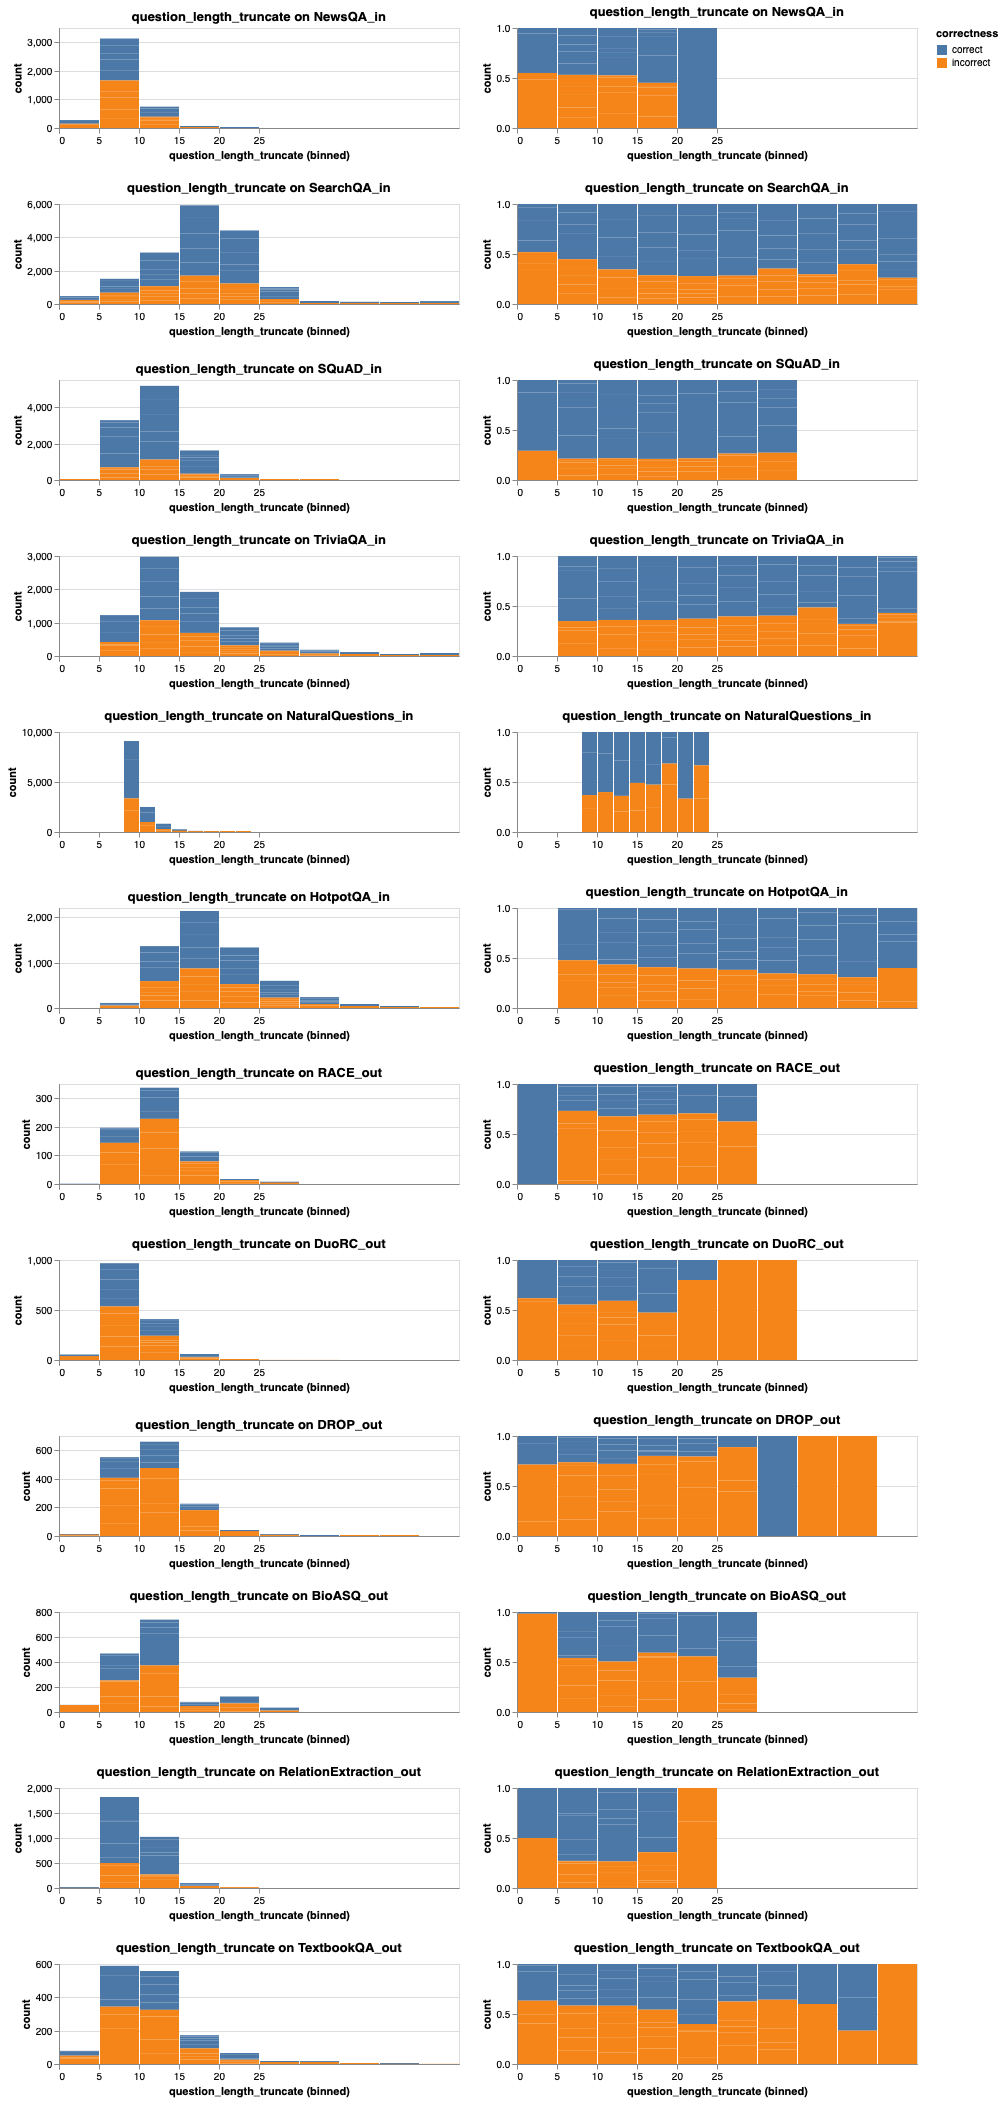

In [41]:
import altair as alt
Attribute.create(
    name="question_length_truncate", 
    description="...", 
    cmd='truncate(attr:question_length, 0, 50)',
    group_hash=Group.store_hash(),
    attr_hash=Attribute.store_hash())
visualize_attr_by_dataset_group("question_length_truncate")

100%|██████████| 12/12 [00:02<00:00,  7.10it/s]


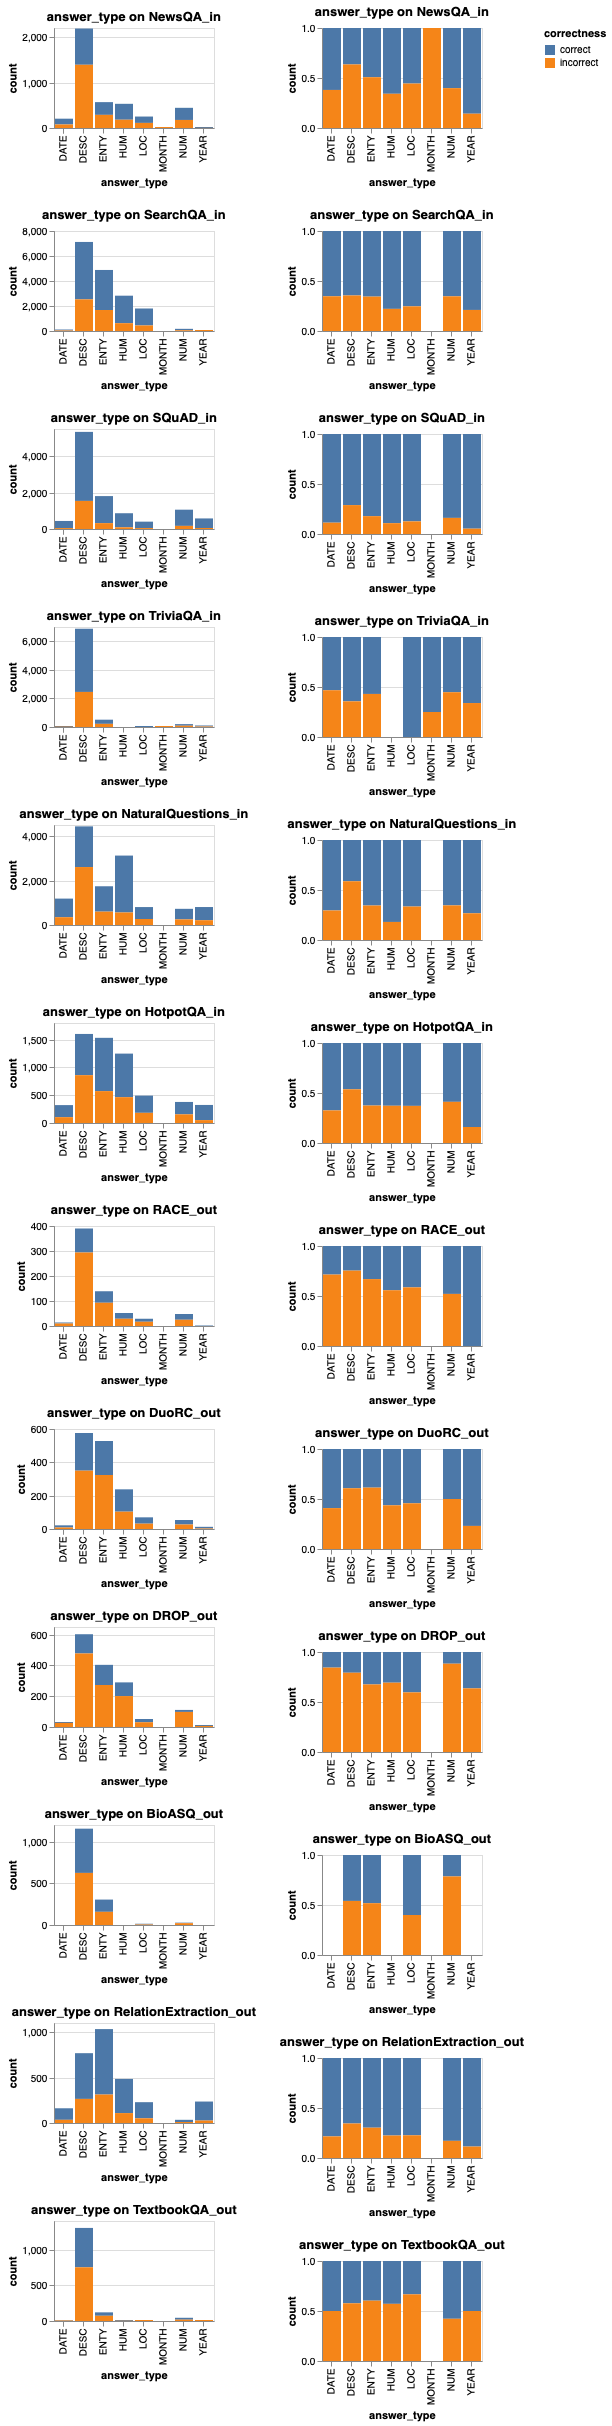

In [67]:
visualize_attr_by_dataset_group("answer_type")

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(truncate):[ArgOp:[BuildBlockOp](attr):context_length, ArgOp:0.0, ArgOp:1000.0]+[]
INFO:errudite.builts.attribute:Created attr: context_length_truncate
100%|██████████| 12/12 [00:01<00:00,  8.26it/s]


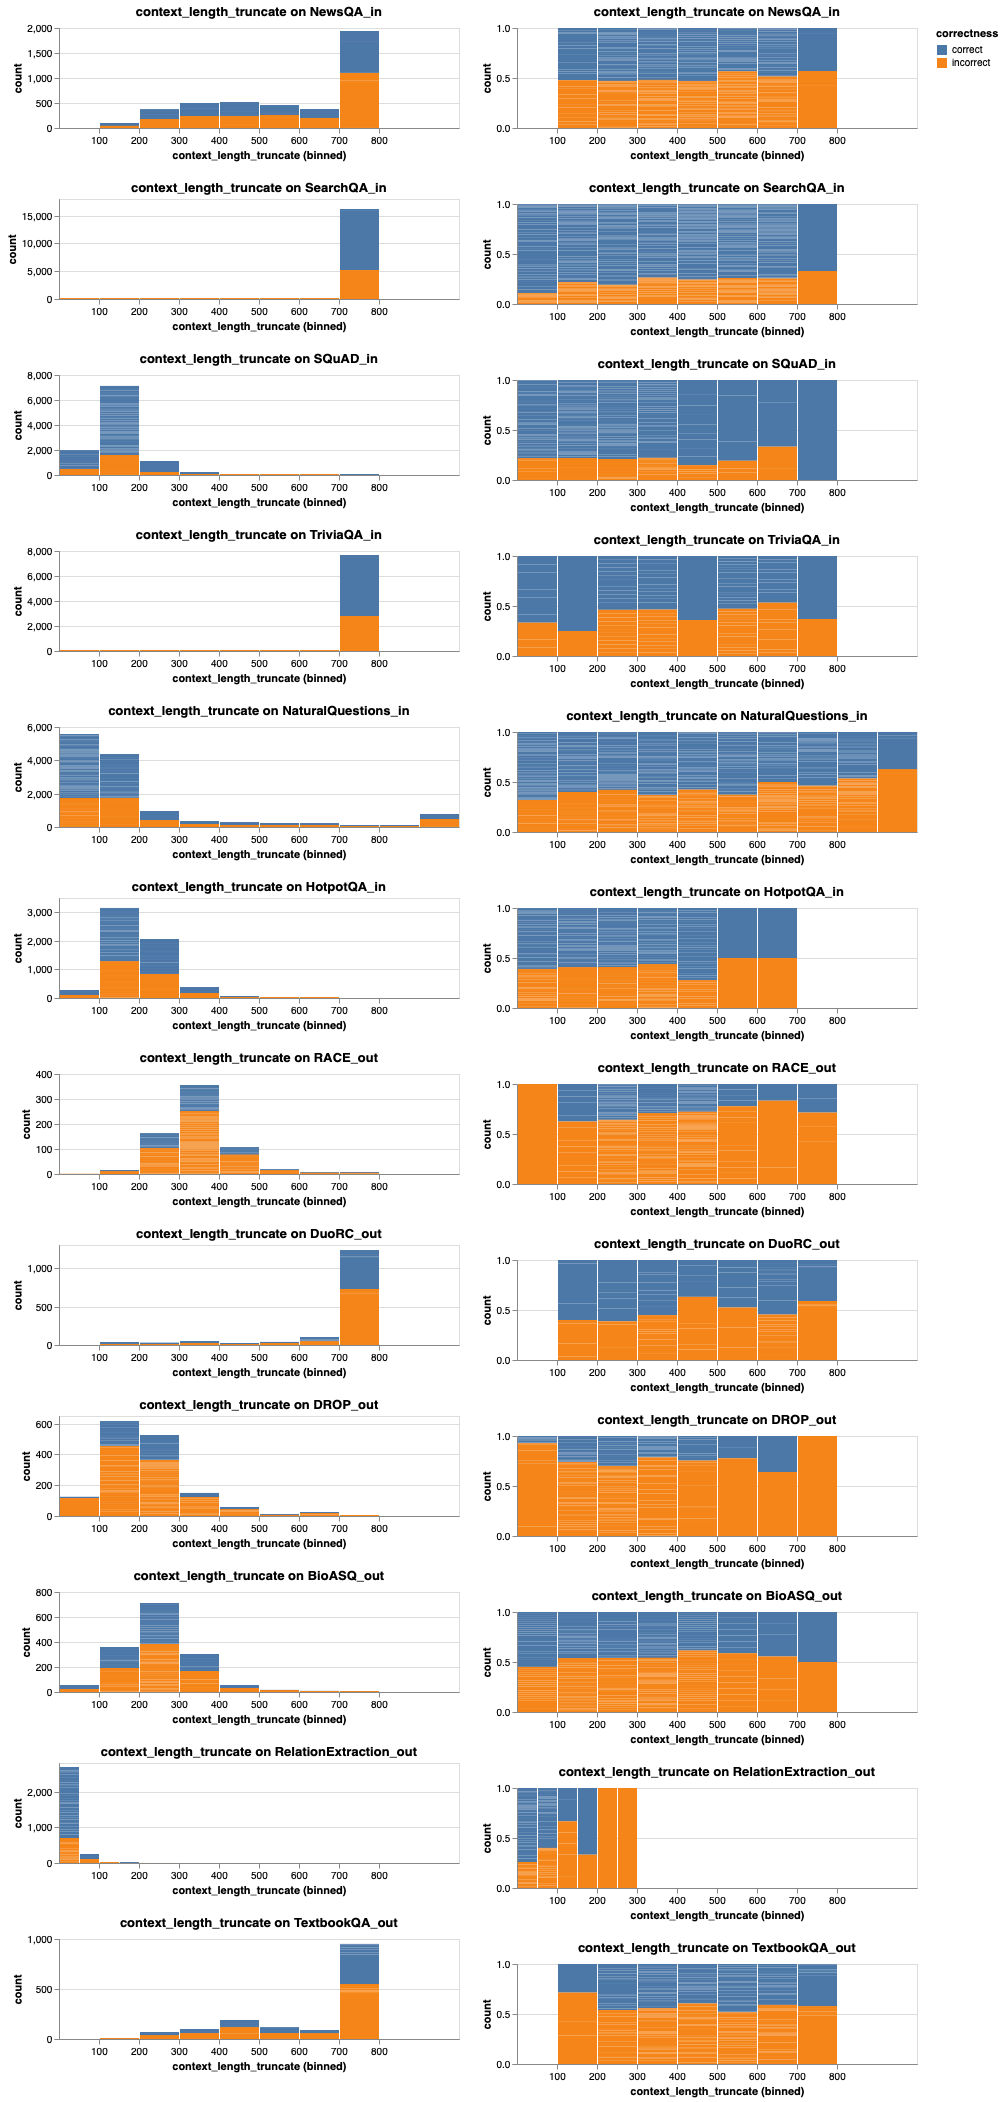

In [56]:
import altair as alt
Attribute.create(
    name="context_length_truncate", 
    description="...", 
    cmd='truncate(attr:context_length, 0, 1000)',
    group_hash=Group.store_hash(),
    attr_hash=Attribute.store_hash())
visualize_attr_by_dataset_group("context_length_truncate")

100%|██████████| 12/12 [00:01<00:00, 11.07it/s]


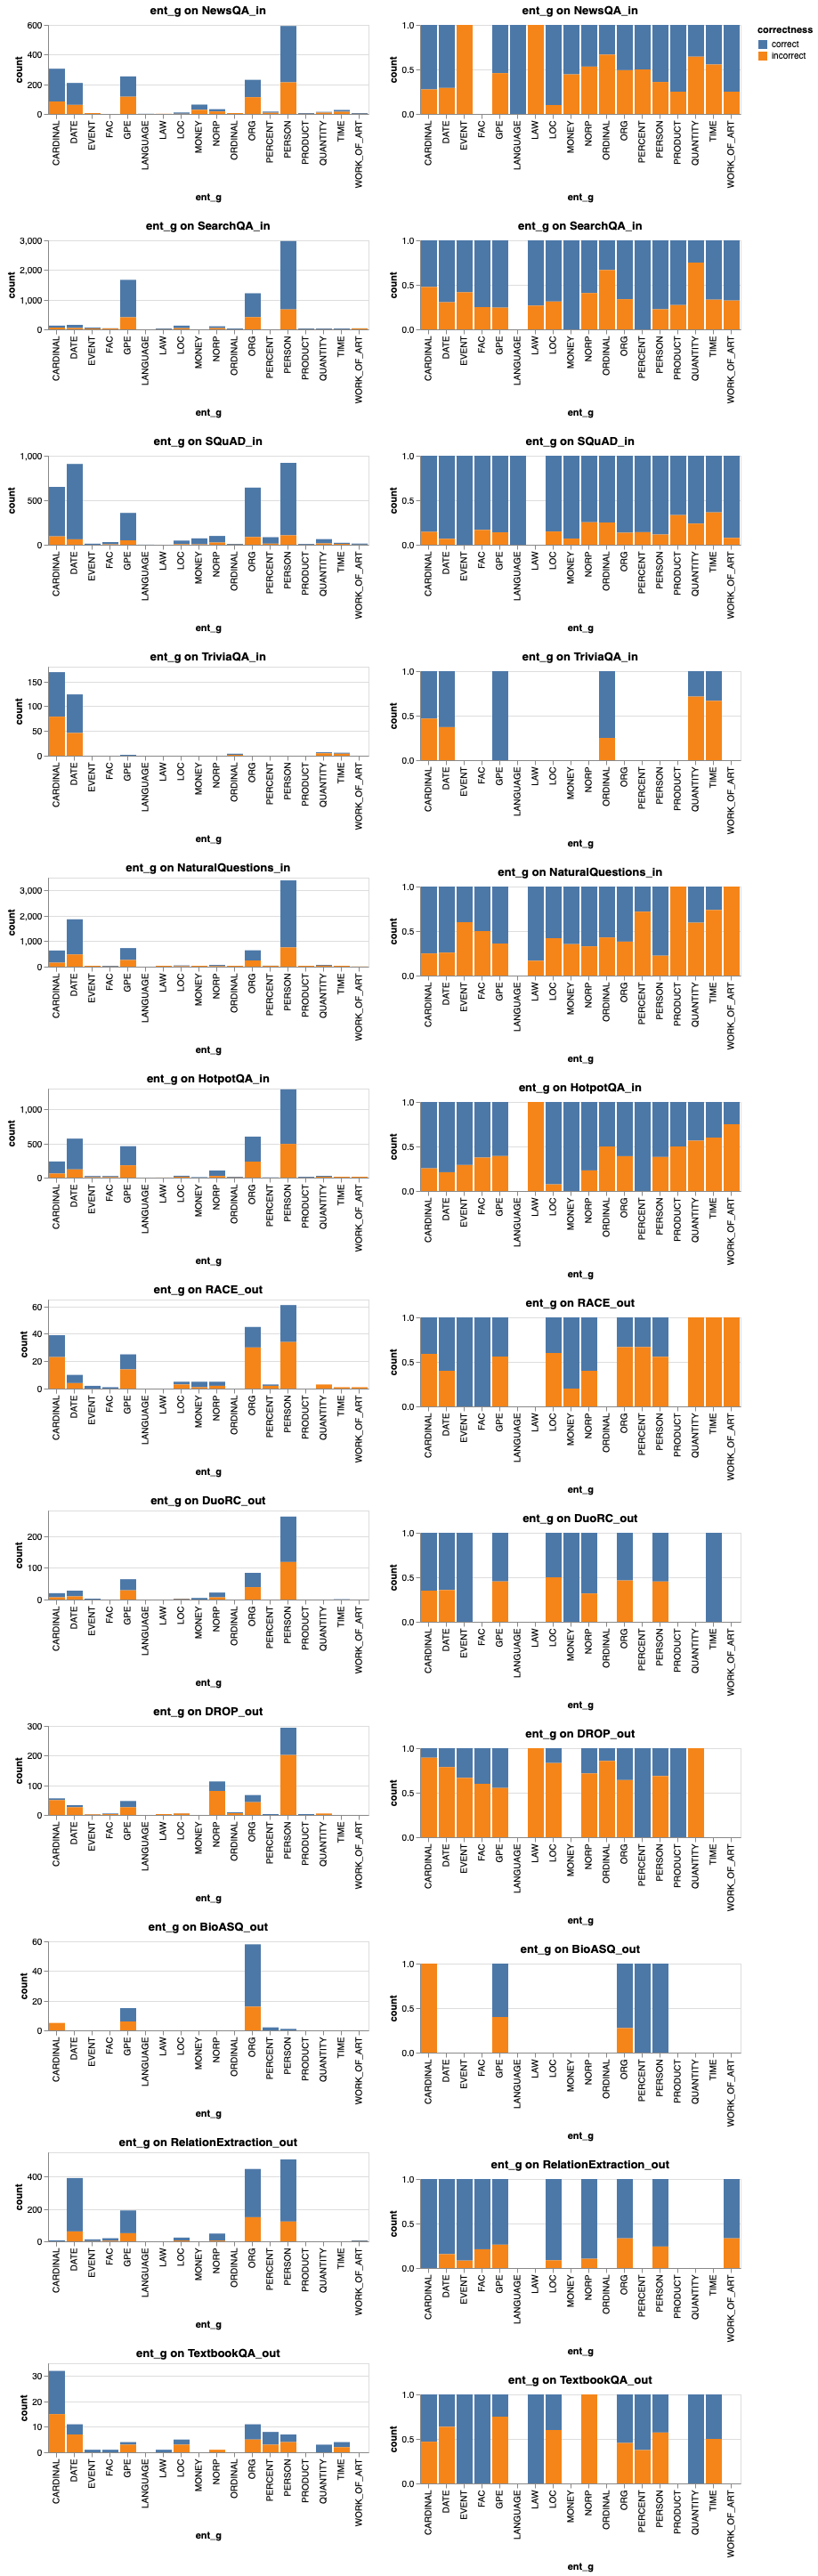

In [57]:
visualize_attr_by_dataset_group("ent_g")

100%|██████████| 12/12 [00:02<00:00,  5.62it/s]


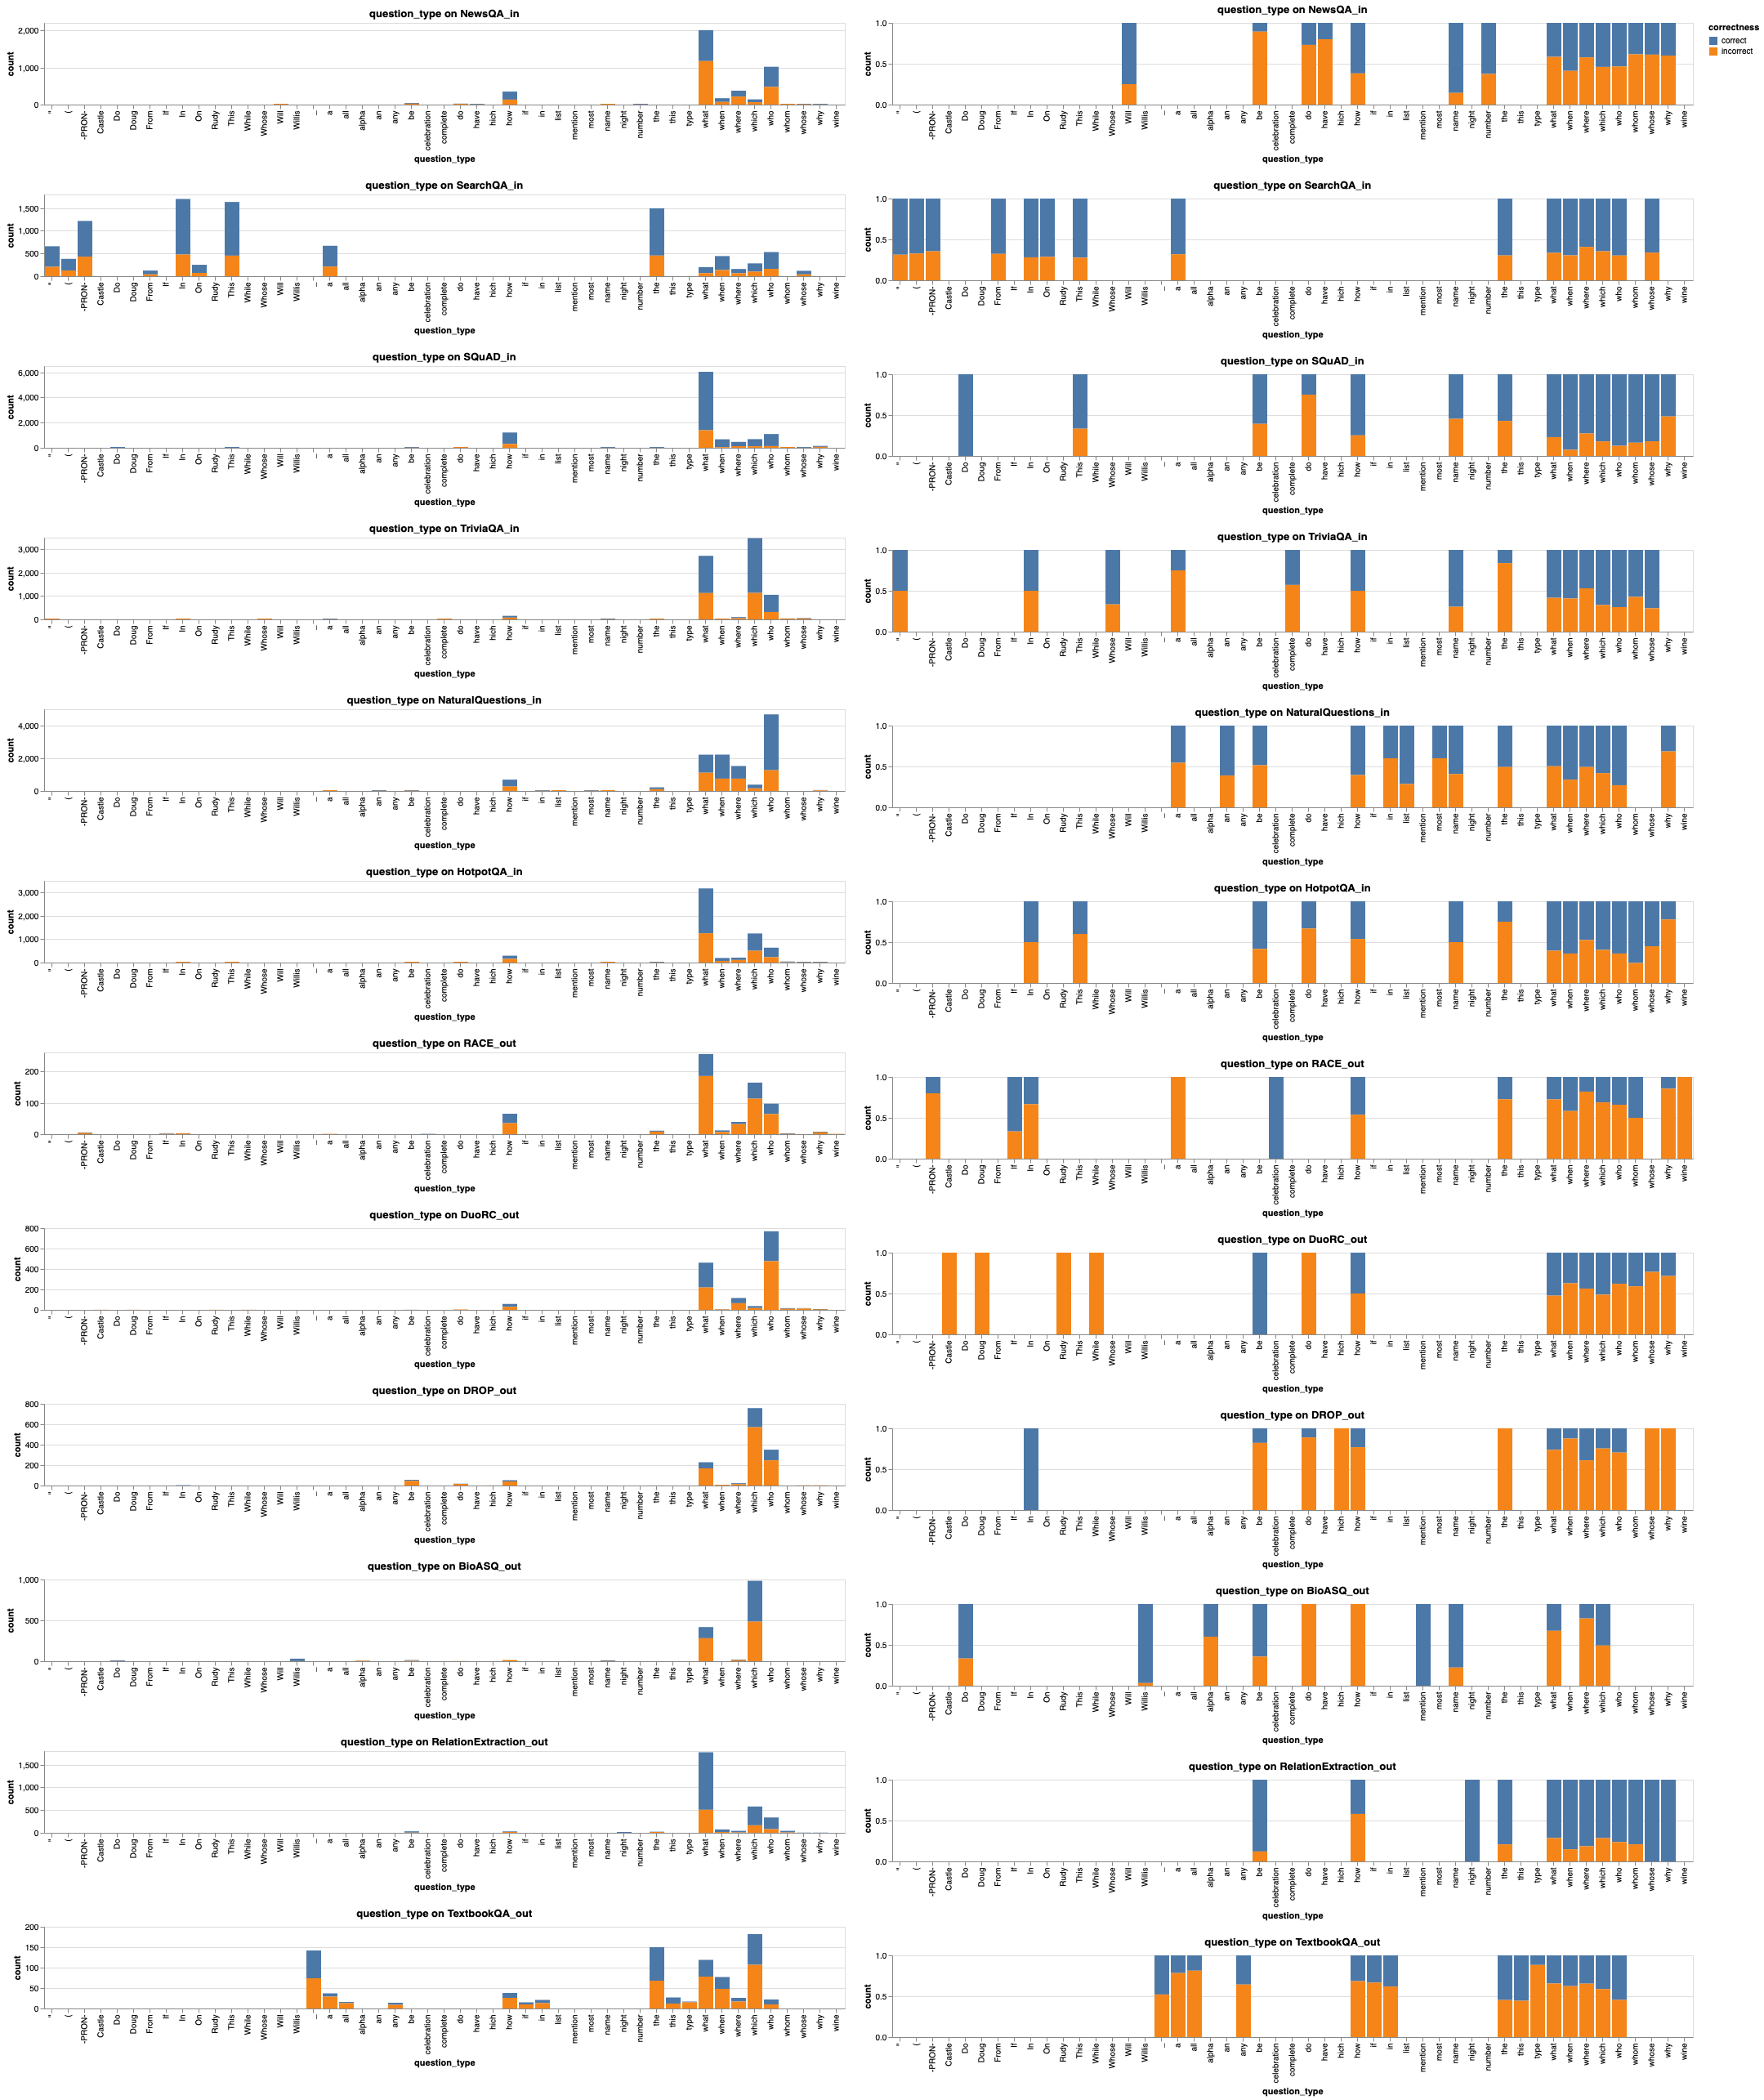

In [72]:
visualize_attr_by_dataset_group("question_type")

In [ ]:
visualize_attr_by_dataset_group("question_length_truncate")